# Notebook for dhcp and others dataset
Pre-processing steps and checks

In [1]:
import ants
import subprocess
import nibabel as nib
import pandas as pd 
import utils as ut
from natsort import natsort_keygen

## Data 
For example purpose and simplification, we use a single sample dhcp scan in this notebook.  
But all actions and code can be run on entire datasets.  

In [2]:
t2_scan = 'sub-CC00058XX09_ses-11300_T2w.nii.gz'

Checking the data from the file  
[Working with nifti](https://nipy.org/nibabel/nifti_images.html)

In [3]:
im = nib.load(t2_scan)
print(im.header) # pixdim of 0.5mm^3 is a bit of a problem for the next steps

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 290 290 203   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.     0.5    0.5    0.5    0.001  0.     0.     0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.11'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 71.712585
qoffset_y       : -57.351707
qoffset_z       : -42.92

## Step 1 : registration 
[Image registration](https://3dqlab.stanford.edu/image-registration/)  + [and this](https://github.com/ANTsX/ANTs/wiki/Tips-for-improving-registration-results)  
In MRI research, registration is usually necessary to align the image with some normalized resolution (spacing), position (direction), contrast and bias field suppression.  
Here we perform it with ants-py.  

UPDATE : I found some published work on the creation of atlases from the same dhcp dataset I'm using, so I'll use this for registration. [link](https://gin.g-node.org/BioMedIA/dhcp-volumetric-atlas-groupwise).  
(Large git)

IMPORTANT : in neonatal dataset the age is in WEEKS, thus there is a template for each week.  
We have the age of the scans from the source data.  

In [4]:
# csvpath = '/Users/arnaud/downloads/bobs_mri/participants.tsv' # BOBS participants
csvpath = 'dhcp_participants.tsv'
ds_info = pd.read_csv(csvpath, sep ='\t')
ds_info.head()

,participant_id,gender,birth_age,birth_weight,singleton
0,CC00549XX22,Female,42.000000,3.685,Single
1,CC00576XX16,Male,28.857143,0.850,Single
2,CC00202XX04,Male,38.571429,2.630,Single
3,CC00720XX11,Female,40.428571,3.950,Single
4,CC00388XX18,Female,34.428571,2.800,Single


Sort both scans and table

In [5]:
sorted_ds = ds_info.sort_values(
    by="participant_id",
    key=natsort_keygen()
)
sorted_ds.head()

,participant_id,gender,birth_age,birth_weight,singleton
174,CC00058XX09,Male,40.285714,4.135,Single
132,CC00060XX03,Female,40.142857,2.845,Single
479,CC00062XX05,Female,41.285714,4.050,Single
33,CC00063AN06,Female,35.142857,1.950,Multiple
477,CC00065XX08,Male,40.428571,3.400,Single


Example test:  
**requires download of the registration repo**  
first subject is gest. age 40, T2 

In [6]:
atlases = "/Users/arnaud/Documents/GitHub/dhcp-volumetric-atlas-groupwise" ## Replace with your path
template_dhcp_42_t2 = ants.image_read(f'{atlases}/mean/ga_42/template_t2.nii.gz')
im0_t2 = ants.image_read(t2_scan)
im0_t2, template_dhcp_42_t2

(ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (290, 290, 203)
 	 Spacing    : (0.5, 0.5, 0.5)
 	 Origin     : (-71.7126, 57.3517, -42.927)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.],
 ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (202, 274, 217)
 	 Spacing    : (0.5, 0.5, 0.5)
 	 Origin     : (-51.9688, 84.5313, -39.0078)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.])

In [7]:
# Perform registration with SyN algorithm
transformed_image = ants.registration(fixed=template_dhcp_42_t2, moving=im0_t2, type_of_transform='SyN') 

In [8]:
print(f"Source scan shape : {im.get_fdata().shape}")
print(f"Registered scan shape : {transformed_image['warpedmovout'].shape}")

Source scan shape : (290, 290, 203)
Registered scan shape : (202, 274, 217)


The transformed image has the resolution of the template

In [9]:
# print(f"Saved registered image to {os.path.abspath(output_path)}. \n")
ants.image_write(transformed_image['warpedmovout'], "./sample/registered_0.nii.gz")
nib.load("./sample/registered_0.nii.gz").get_fdata().shape

(202, 274, 217)

Some 2D visualization

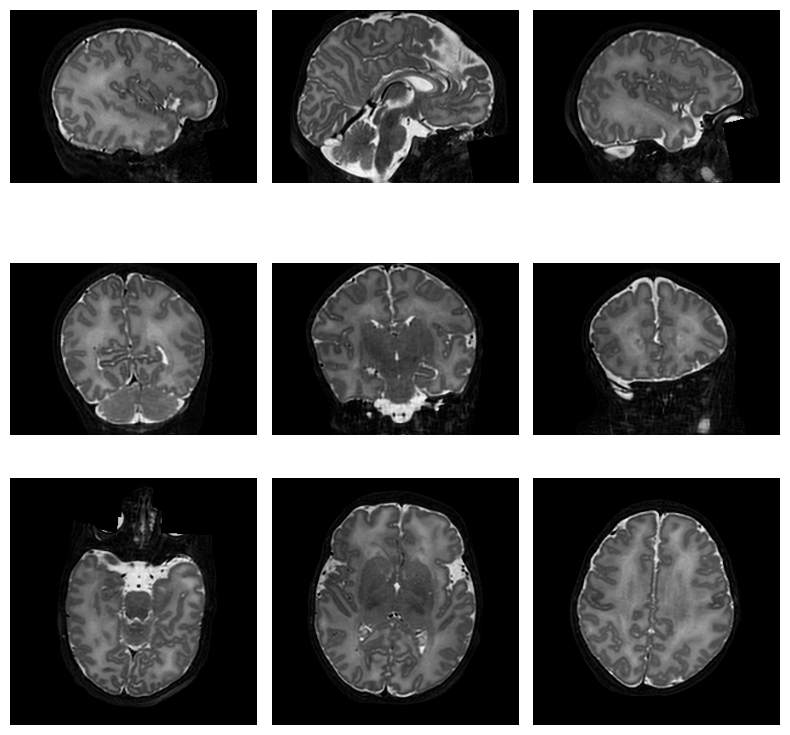

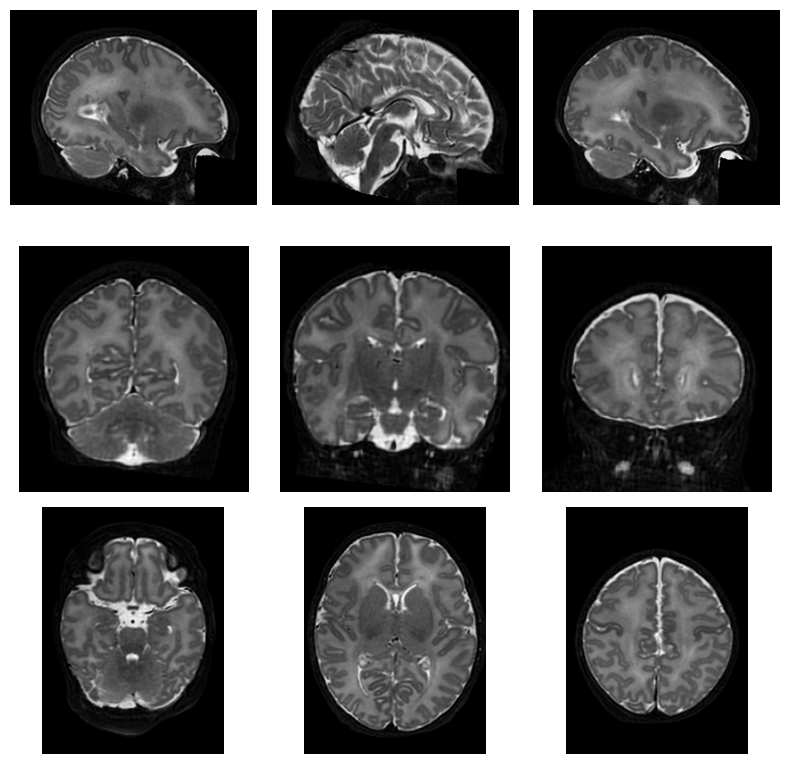

In [10]:
plot = ut.visualize_nifti_depth(t2_scan)
plot = ut.visualize_nifti_depth("./sample/registered_0.nii.gz")

In [11]:
# I have done ALL the previous registration on the whole dhcp dataset with an other atlas,
# which is not great in terms of precision, but at least I know how to do it. 
# template_file1 = ants.image_read("./registre/Akiyama_6Month_1_5T.nii.gz")
# template_file3 = ants.image_read("./registre/Akiyama_6Month_3T.nii.gz")

## Step 2 : skull-strip  
After the registration, we can perform skull-striping.  
This is not necessary for the brain segmentation tool, but it can be usefull to keep the skull vs brainmatter.  
**Do we need it before or after registration ?** -> depends what we do with the brain vs skull, shouldnt change too much

Skullstrip takes *input*, *output_path* and *mask_path* arguments.  
Mask is the binary brain mask.  
Docker version, so have it ready too. 

In [12]:
# Check and start Docker if necessary
if not ut.is_docker_running():
    print("Docker is not running. Starting it now...")
    ut.start_docker()
else:
    print("Docker is running.")

Docker is running.


In [13]:
# Using sample 0 again for test :
inp = './sample/registered_0.nii.gz'
out = './sample/brain_0.nii.gz'
mask = './sample/mask_0.nii.gz'
strip_process = subprocess.run([f'./synthstrip.py -i {inp} -o {out} -m {mask} --no-csf'], shell = True) # no csf : exclude csf 

Configuring model on the CPU
Running SynthStrip model version 1
Excluding CSF from brain boundary
Input image read from: /Users/arnaud/Documents/GitHub/mri_fractal/data_pipeline/sample/registered_0.nii.gz
Processing frame (of 1): 1 done
Masked image saved to: /Users/arnaud/Documents/GitHub/mri_fractal/data_pipeline/sample/brain_0.nii.gz
Binary brain mask saved to: /Users/arnaud/Documents/GitHub/mri_fractal/data_pipeline/sample/mask_0.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474

Website: https://w3id.org/synthstrip



Skull is simply the full brain scan without the brain matter then, or without binary mask

In [14]:
img_raw   = nib.load(inp)
img_brain = nib.load(out)
skull = img_raw.get_fdata() - img_brain.get_fdata()
skull = nib.Nifti1Image(skull, img_raw.affine)
nib.save(skull, f"./sample/skull_0.nii.gz")

## Step 3 : segmentations
Using synthseg tool 2 main options here : with or without cortical parcellation.  
Cortical parcellation means that we segment the upper part of the brain in even more known brain parts, unecessary if we want to use the white/gray matter for FD later.  

Installation was done from [docker]() or [Freesurfer 7.4.1](https://surfer.nmr.mgh.harvard.edu/fswiki/rel7downloads), it can also be *simply* installed [locally](https://github.com/BBillot/SynthSeg) and.  
We run a docker version since we use it for the skullstrip anyways : 

In [15]:
inp = './sample/registered_0.nii.gz' 
out = './sample/segmented_0.nii.gz'
csv_path, qc_path = './sample/vol_0.csv', './sample/qc_0.csv' # come with builtin recap of volumes and quality check

# parcellation
cmd_parc = f'./synthseg.py --i {inp} --o {out} --vol {csv_path} --qc {qc_path} --parc --robust --cpu --threads 8'
# no parcellation
cmd_no_parc = f'./synthseg.py --i {inp} --o {out} --vol {csv_path} --qc {qc_path} --robust --cpu --threads 8'

seg_process = subprocess.run([cmd_no_parc], shell = True)

Using TensorFlow backend.
usage: SynthSeg_predict.py [-h] [--i I] [--o O] [--parc] [--robust] [--fast]
                           [--ct] [--vol VOL] [--qc QC] [--post POST]
                           [--resample RESAMPLE] [--crop CROP [CROP ...]]
                           [--threads THREADS] [--cpu] [--v1]
SynthSeg_predict.py: error: argument --threads: invalid int value: '/Users/arnaud/Documents/GitHub/mri_fractal/data_pipeline/8'


Error running image.


## Step 4 : Fractal dimension calculation
Using a function inspired from   
Although it can be performed at any moment, we use it here after the previous pre-processing steps of the pipeline

In [16]:
ut.fractal_analysis(t2_scan)

The voxel size is 0.5 x 0.5 x 0.5 mm^3
Shape of the image : (290, 290, 203)
The minimum size of the image is 0.5 mm
The maximum size of the image is 290 mm
The non-zero voxels in the image are (the image volume) 6560172 / 17072300
Computing scale 1...
Computing scale 2...
Computing scale 4...
Computing scale 8...
Computing scale 16...
Computing scale 32...
Computing scale 64...
Computing scale 128...
Computing scale 256...
Computing scale 512...
In the interval [1, 512] voxels, the FD is 2.4068825395642945 and the determination coefficient adjusted for the number of points is 0.9800717344713169
In the interval [1, 256] voxels, the FD is 2.5666725255483844 and the determination coefficient adjusted for the number of points is 0.9913870474460585
In the interval [2, 512] voxels, the FD is 2.312273836247687 and the determination coefficient adjusted for the number of points is 0.9767916742116011
In the interval [1, 128] voxels, the FD is 2.675616957260251 and the determination coefficient 

### To document :  FD on all segmentations

## ( Step X : synthetic brain generation )
 - other future step for PhD thesis
 - separated notebook
 - requires full synthseg repo and my tests
 - further test needed : 
    - needs more than 1 reference labels map, but how many 
    - some tests with the variations
    - some tests without some parts